Author: Kaveh Mahdavi <kavehmahdavi74@yahoo.com>
License: BSD 3 clause
last update: 28/12/2022

# Binary Classification in TensorFlow

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
# Classes
class BColors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


# Functions
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %': na_df})
        missing_data.plot(kind="barh")
        plt.show()
    else:
        print(BColors.OKGREEN + 'No NaNs found' + BColors.ENDC)
    print(df.isnull().sum())


def plot_cm(cm, _plot=False):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
        cm (array 2d): confusion matrix
       _plot (bool): If True, it plots the graph.

    Return:
        A figure object
    """
    fig, ax = plot_confusion_matrix(conf_mat=cm)
    if _plot:
        plt.show()
    else:
        return fig


def eval_plot(_history, xy=[], titel=None):
    """ Plots the model history evaluation

    :param _history (pandas): Includes the evaluation data
    :param xy (list): Includes the name of the x and y features
    :param titel (str): The plot name
    """
    plt.plot(_history.history[xy[0]])
    plt.plot(_history.history[xy[1]])
    plt.title(titel)
    plt.ylabel(xy[0])
    plt.xlabel(xy[1])
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

## Load Data


### About Dataset

This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact
 whether the customer left the bank (closed his account) or he continues to be a customer.

In [3]:
# Load data from Github
data_url = 'https://raw.githubusercontent.com/kavehmahdavi/TF_Portfolio/main/data/Churn_Modelling.csv'
data = pd.read_csv(data_url)

## Prepare and Clean Data

In [4]:
# Shuffle Data
data = shuffle(data)
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
21,22,15597945,Dellucci,636,Spain,Female,32,8,0.00,2,1,0,138555.46,0
4719,4720,15583580,Chiawuotu,566,Germany,Female,35,1,123042.00,1,1,0,66245.44,1
4651,4652,15579996,Iroawuchi,524,Germany,Female,25,7,131402.21,1,0,0,193668.49,0
4372,4373,15730137,Udegbulam,628,France,Male,31,0,88421.81,1,0,0,72350.47,0
4605,4606,15585599,Stone,530,France,Female,34,8,0.00,2,0,1,141872.52,0


In [5]:
# Drop Nan Features
plot_nas(data)

No NaNs found
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [6]:
# Balance Class
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

As you can see, only about 20% of the observations were balanced. Therefore, if we were to always predict class_1, we’d achieve an accuracy of 80%.
We use Up-sample minority Class to balance classes.

In [7]:
# Separate majority and minority classes
df_majority = data[data.Exited == 0]
df_minority = data[data.Exited == 1]

# Down_sample majority class
df_minority_up_sampled = resample(df_minority,
                                  replace=True,
                                  n_samples=df_majority.shape[0],
                                  random_state=4)

data = pd.concat([df_majority, df_minority_up_sampled])
data['Exited'].value_counts()

0    7963
1    7963
Name: Exited, dtype: int64

### Setup Feature and Label Data

In [8]:
# Drop Useless columns
features = data.drop(labels=['CustomerId', 'Surname', 'RowNumber', 'Exited'], axis=1)
label = data['Exited']

features.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
dtype: object

In [9]:
# Encode Categorical Variables
cat_var = ['Gender', 'Geography']
encoder = LabelEncoder()
for _var in cat_var:
    features[_var] = encoder.fit_transform(features[_var])

features = pd.get_dummies(features, drop_first=True, columns=['Geography'])
features.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_1,Geography_2
9262,734,0,52,6,71283.09,2,0,1,38984.37,1,0
1947,688,1,52,1,0.00,2,1,1,172033.57,0,0
5822,624,1,35,2,0.00,2,1,0,87310.59,0,1
1320,687,0,47,7,0.00,2,1,1,177624.01,0,0
2925,717,0,76,9,138489.66,1,1,1,68400.14,0,0


In [10]:
# Normalize data
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [11]:
# Split Data into Train, Validation and Test
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3)

# Reserve 10,000 samples for validation
x_val = X_train[-1000:]
y_val = y_train[-1000:]
X_train = X_train[:-1000]
y_train = y_train[:-1000]


/tmp/ipykernel_35350/1004199854.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_val = y_train[-1000:]
/tmp/ipykernel_35350/1004199854.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train = y_train[:-1000]


## Create a Keras sequential model

In [12]:
# Init TensorBoard
logdir = os.path.join("log", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [24]:
# Create linear stack of layers
bc_model = tf.keras.models.Sequential([tf.keras.layers.Dense(128, activation='relu', input_dim=X_train.shape[1]),
                                       tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(64, activation='relu'),
                                       tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(32, activation='relu'),
                                       tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(1, activation='sigmoid')])
bc_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 128)               1536      
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_41 (Dense)            (None, 64)                8256      
                                                                 
 dropout_31 (Dropout)        (None, 64)                0         
                                                                 
 dense_42 (Dense)            (None, 32)                2080      
                                                                 
 dropout_32 (Dropout)        (None, 32)                0         
                                                                 
 dense_43 (Dense)            (None, 1)               

In [14]:
# Compiling Model
bc_model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

In [15]:
# Train Model
history = bc_model.fit(X_train, y_train,
                       batch_size=32,
                       epochs=50,
                       validation_data=(x_val, y_val),
                       verbose=1,
                       callbacks=[tensorboard_callback])

Epoch 1/50
318/318 [==============================] - 5s 8ms/step - loss: 0.5617 - accuracy: 0.7100 - val_loss: 0.4614 - val_accuracy: 0.7940
Epoch 2/50
318/318 [==============================] - 2s 7ms/step - loss: 0.4930 - accuracy: 0.7590 - val_loss: 0.4301 - val_accuracy: 0.8090
Epoch 3/50
318/318 [==============================] - 2s 7ms/step - loss: 0.4700 - accuracy: 0.7738 - val_loss: 0.4213 - val_accuracy: 0.8030
Epoch 4/50
318/318 [==============================] - 2s 7ms/step - loss: 0.4621 - accuracy: 0.7809 - val_loss: 0.4111 - val_accuracy: 0.8000
Epoch 5/50
318/318 [==============================] - 2s 7ms/step - loss: 0.4521 - accuracy: 0.7866 - val_loss: 0.4140 - val_accuracy: 0.8020
Epoch 6/50
318/318 [==============================] - 2s 6ms/step - loss: 0.4518 - accuracy: 0.7822 - val_loss: 0.4074 - val_accuracy: 0.8140
Epoch 7/50
318/318 [==============================] - 2s 6ms/step - loss: 0.4454 - accuracy: 0.7865 - val_loss: 0.4126 - val_accuracy: 0.8240
Epoch 

Exception ignored in: <function UniquePtr.__del__ at 0x7f08cc7eba60>
Traceback (most recent call last):
  File "/home/kaveh/software/pycharm-community-2016.3.2/PycharmProjects/venv/TF_Portfolio/lib/python3.8/site-packages/tensorflow/python/framework/c_api_util.py", line 70, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [639]:
# Load tensorboard
%load_ext tensorboard
%tensorboard --logdir log

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

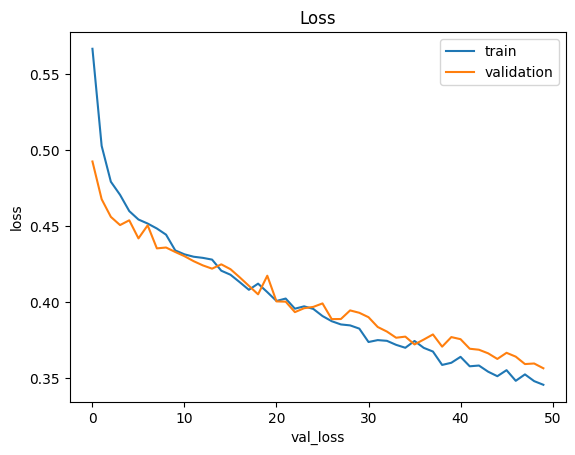

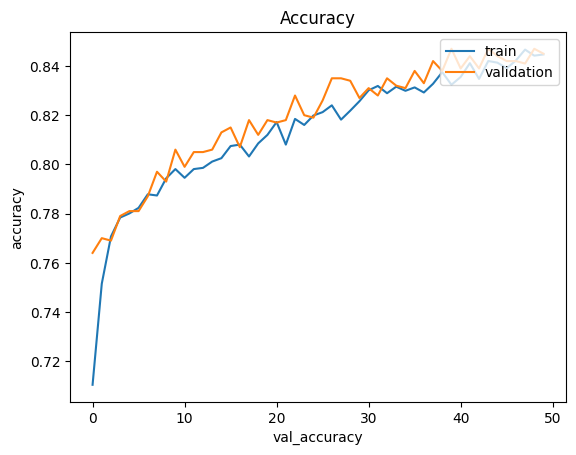

In [625]:
# Evaluate Model
eval_plot(history, ['loss', 'val_loss'], 'Loss')
eval_plot(history, ['accuracy', 'val_accuracy'], 'Accuracy')

In [626]:
# Test Model
test_scores = bc_model.evaluate(X_test, y_test)
print('Test Loss: ', test_scores[0])
print('Test accuracy: ', test_scores[1] * 100)

150/150 [==============================] - 0s 2ms/step - loss: 0.3896 - accuracy: 0.8280
Test Loss:  0.3896215856075287
Test accuracy:  82.79615044593811
